# Quantum Phase Estimation

Dependancies for this notebook:

In [1]:
from qiskit.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile 
from qiskit.circuit.library import UnitaryGate, QFT
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from scipy.linalg import expm
pi = np.pi

## Table of Contents

* [Overview](#overview)
* [Algorithm](#algo)
    * [Final State Proof](#fsp)
    * [Examples](#algo_examples)
* [Error Analysis](#error)

## Overview <a name="overview"></a>
Similar to the HTs, the quantum phase estimation algorithm (QPE) is a fundamental algorithm in quantum computing used to find the phase of a given eigenstate $|\psi\rangle$ of a unitary operator $U$. Most modern phase estimation algorithms build upon QPE one way or another, therefore understanding the textbook version of QPE is crucial for understanding much more complex quantum algorithms. Similarly to the HTs, the phase of $U$ is written onto an ancilla registry, but instead of consisting of only one qubit the ancilla registry for QPE consists of multiple qubits, which is leveraged for higher accuracy. 
        
To encode $\varphi$ onto multiple qubits, $CU$ gates are applied multiple times to each single qubit to isolate a specific binary digit of $\varphi$. These rotations done in succession will encode $\varphi$ into the Fourier basis, then using the IQFT, the state vector will be transformed into the computational basis for measurement.

## Algorithm <a name = "algo"></a>
Let $U \in \mathbb{C}^{n\times n}$ be unitary. The quantum phase estimation algorithm is defined via the circuit below.

![QPE Circuit](images/5-qpe_circuit.png) 

*Quantum phase estimation circuit where $H$ is the Hadamard gate, $U \in \mathbb{C}^{n \times n}$ is unitary and $QFT^{\dagger}$ is the inverse QFT. The top qubits are the ancilla qubits and the bottom qubits represent the state $|\psi\rangle$.*

### Final State Proof <a name="fsp"></a>

The initial state of the circuit shown above can be represented as
\begin{equation}
|\psi_0\rangle = |0\rangle^{\otimes n}|\psi\rangle.
\end{equation}
A Hadamard gate is then applied to all $n$ ancilla qubits putting them into superposition, i.e.,
\begin{equation}
|\psi_1\rangle = \frac{1}{\sqrt{2^n}}(|0\rangle + |1\rangle)^{\otimes n}|\psi\rangle = |+\rangle^{\otimes n}|\psi\rangle.
\end{equation}
Next the controlled $U$ gates are applied. Since $U|\psi\rangle = e^{2\pi i\varphi}|\psi\rangle$, when applying this gate to all $n$ qubits, it follows that
\begin{equation}
U^{2^j}|\psi\rangle = (e^{2\pi i \varphi})^{2^j}|\psi\rangle = e^{2\pi i 2^j \varphi}|\psi\rangle.
\end{equation}
Therefore, by controlling this gate and applying it to all $n$ qubits, it only affects the state for the case in which it is $|1\rangle$. Applying the controlled $U^{2^j}$, with $0 \leq j \leq n-1$, yields

\begin{equation}
|\psi_2\rangle = \frac{1}{\sqrt{2^n}}\left(|0\rangle + e^{2\pi i \varphi 2^{n-1}}|1\rangle\right) \otimes \dots \otimes \left(|0\rangle + e^{2\pi i \varphi 2^{0}}|1\rangle\right)\otimes|\psi\rangle= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle,
\end{equation}

where $k$ is the integer representation of an $n$-bit binary number. Next the inverse QFT is applied leading to
\begin{equation}
|\psi_3\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i \varphi k}|k\rangle|\psi\rangle \xrightarrow{\text{QFT}_N^\dagger} \frac{1}{2^n}\sum_{x=0}^{2^n-1}\sum_{k=0}^{2^n-1}e^{2\pi i k(\varphi - \frac{x}{2^n})}|x\rangle|\psi\rangle.
\end{equation}

As a reminder, when $n=1$, $\text{QFT}_n = H$, QPE with one ancilla qubit is the same circuit as the real HT.

### Examples <a name = "algo_examples"></a>

Methods used for these examples:

In [2]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits): # through every controlled qubit
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest): # loop through every control qubit
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def plot_distribution(ax, angle, ancilla_bits, counts):
    ax.tick_params(axis = 'x', rotation=90)
    ax.set_ylabel("Probability")
    ax.set_xlabel("Binary String")
    ax.set_title(f"\u03C6= {angle:0.5f}")
    bin_nums = []
    shots  = 0
    for i in counts.values(): shots+=i
    for i in range(2**ancilla_bits):
        bin_nums.append(bin(int(i))[2:])
        bin_nums[i]=bin_nums[i].zfill(ancilla_bits)
    updated_counts = []
    big_prob = []
    big_prob_str = []
    for i in bin_nums:
        try:
            num = counts[i]
        except:
            num = 0
        finally:
            prob = num/shots
            updated_counts.append(prob)
            if prob >0.1:
                big_prob.append(prob)
                big_prob_str.append(i)
    bar = ax.bar(bin_nums, updated_counts)
    bar = ax.bar(big_prob_str, big_prob, width=0)
    ax.bar_label(bar, fmt=lambda x: f" {x:0.2f}", fontsize= 10, rotation=90)
    ax.set_ylim(ymax = max(updated_counts)+.11)

#### Single Qubit QPE

To test QPE, we can define
\begin{equation}
    U = \begin{bmatrix} 1 & 0 \\ 0 & e^{i2\pi \varphi} \end{bmatrix}.
\end{equation}
which is the phase gate.

In [3]:
ancilla_bits = 5
angle = 1/4

In [4]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.25
Binary Representation of the phase angle:  0.01000


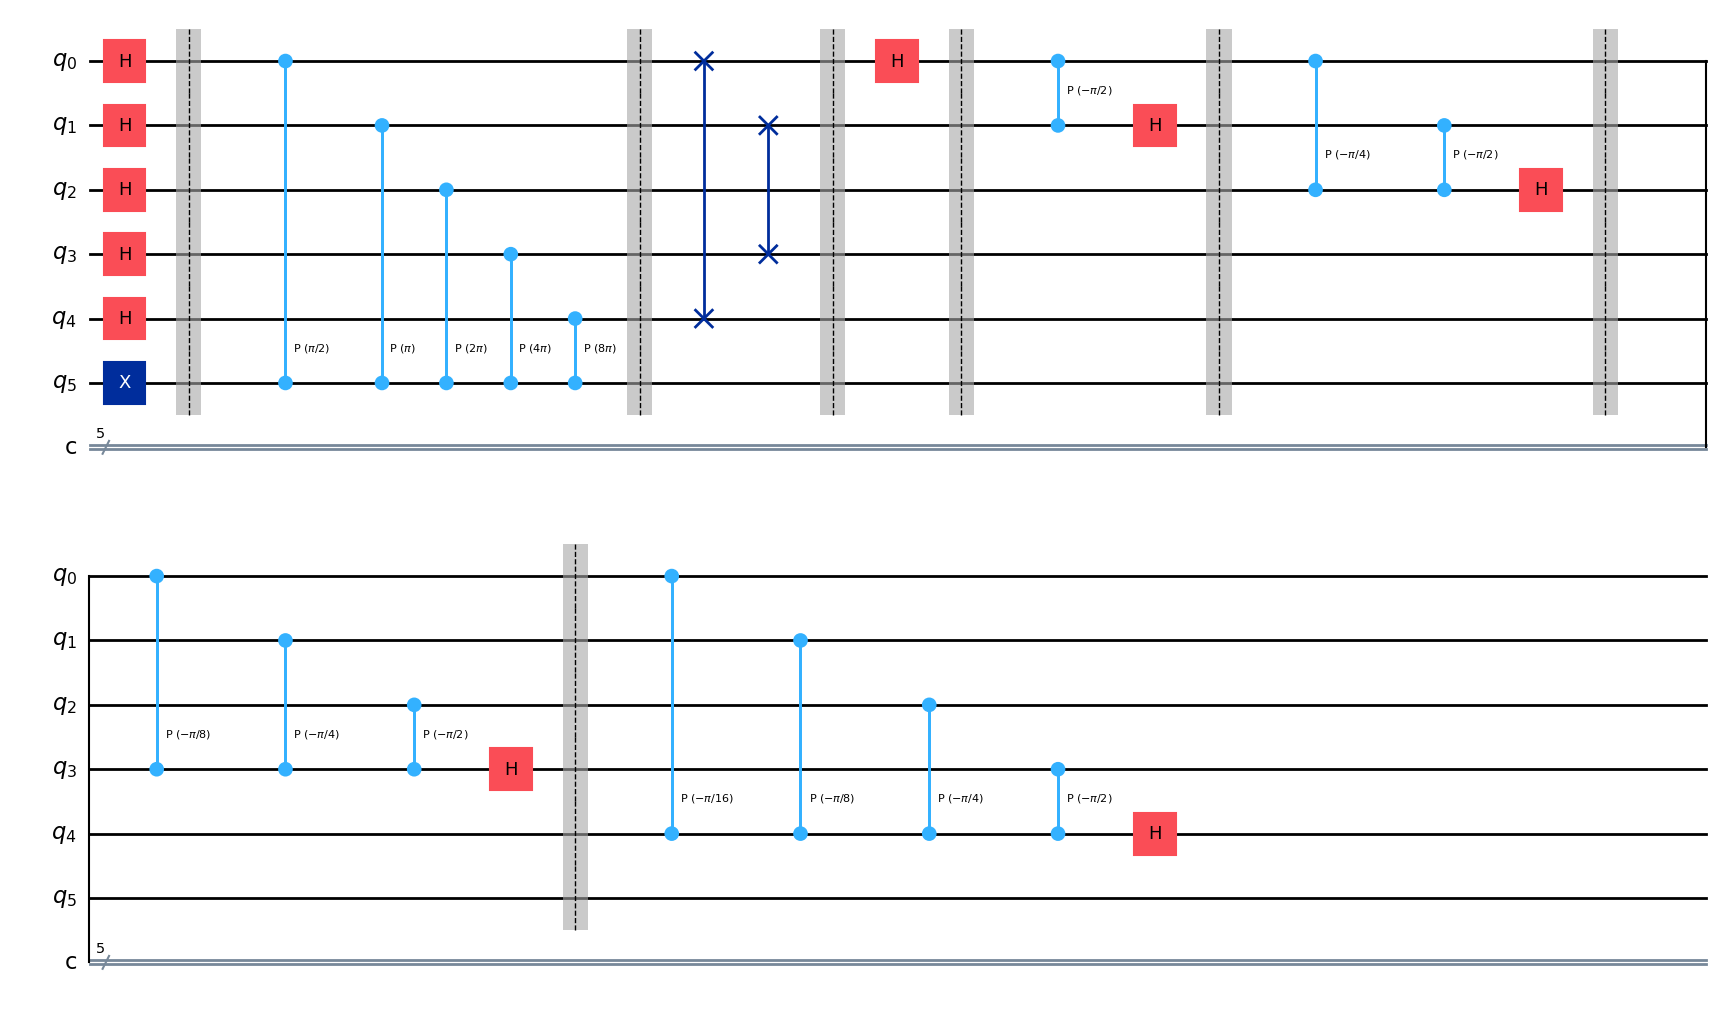

In [5]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
for i in range(ancilla_bits):
    qc.h(i)
qc.x(ancilla_bits)
qc.barrier()
for i in range(ancilla_bits):
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits)
qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
qc.draw('mpl')

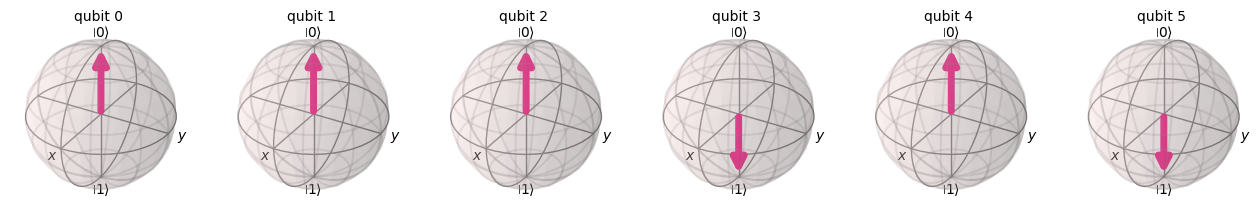

In [6]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

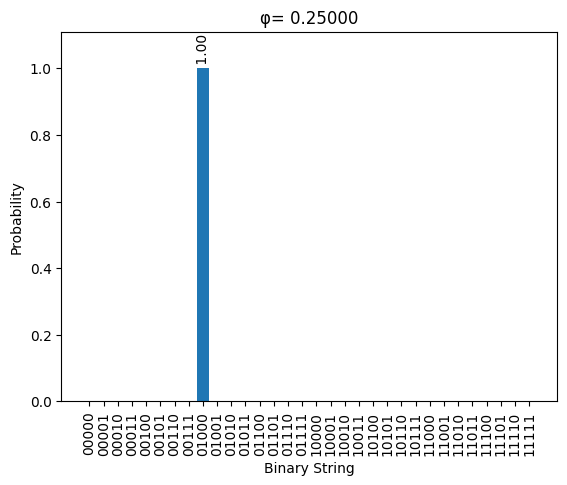

In [7]:
for i in range(ancilla_bits): qc.measure(i,i)

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10**4).result().get_counts()

fig,ax = plt.subplots(nrows = 1, ncols = 1)
plot_distribution(ax, angle, ancilla_bits, counts)
plt.show()

In [8]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.01000
Decimal Number with Equivalent Value: 0.25


Notice when the phase angle $\varphi = \frac{1}{4}$ can be exactly represented with $2$ binary digits, using at least $2$ ancilla qubits in QPE returns the phase angle deterministically.

Contrarily, a phase angle $\varphi = \frac{2}{3}$ cannot be exactly represented with any number of binary digits therefore the outcome is probabilistic.

#### Multiqubit QPE

Interestingly, the input state changes. Suppose we define

\begin{equation}
    U = \begin{bmatrix}e^{2\pi.25}&0&0&0\\0&e^{2\pi.3}&0&0\\0&0&e^{2\pi.4}&0\\0&0&0&e^{2\pi.5}\end{bmatrix}.
\end{equation}


In this case the input state changes the output of QPE.

In [9]:
ancilla_bits = 5
input_state = '01'

In [10]:
eigen_bits = 2
H = np.asarray([[.25,0,0,0],
                [0,.3,0,0],
                [0,0,.4,0],
                [0,0,0,.5]], complex)

print("Hamiltonian:\n", H)

print("\nEigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)

# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

Hamiltonian:
 [[0.25+0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.3 +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.4 +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.5 +0.j]]

Eigenvalues of the Hamiltonian:
 [0.25+0.j 0.3 +0.j 0.4 +0.j 0.5 +0.j]

Lowest energy Eigenvalue (0.25+0j)


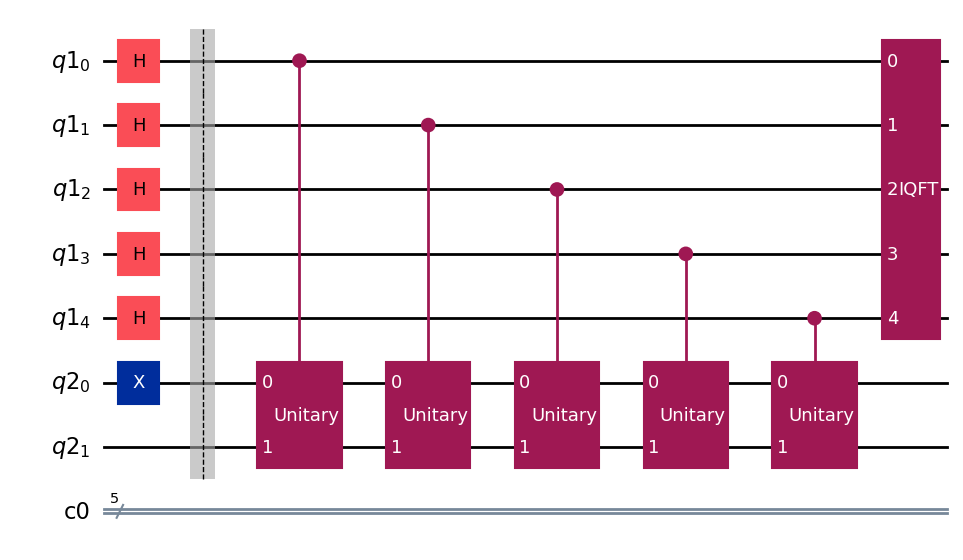

In [11]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

# the input state gets moddified here
if input_state[1] == '1':
    qc.x(qr_eigenstate[0])
if input_state[0] == '1':
    qc.x(qr_eigenstate[1])


qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)

qc.draw('mpl')

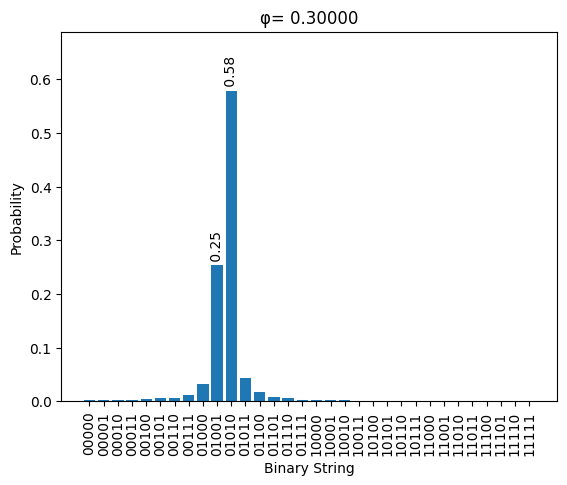

In [12]:
qc.measure(qr_ancilla, cr)

aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10**4).result().get_counts()
fig,ax = plt.subplots(nrows = 1, ncols = 1)
if input_state == '00': angle = .25
if input_state == '01': angle = .3 
if input_state == '10': angle = .4 
if input_state == '11': angle = .5 
plot_distribution(ax, angle, ancilla_bits, counts)
plt.show()

In [13]:
max_num = 0
binary_num = ''
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.25
Binary Number Output: 0.01010
Decimal Number with Equivalent Value: 0.3125


## Error Analysis <a name = "error"></a>
For a general matrix it is not guaranteed that its eigenvalues have a finite binary representation. Thus quantifying the error arising from using a finite binary approximation in the QPE algorithm is the subject of this section.
It can be assumed for a unitary operator $U$ that 
\begin{equation}
U|\psi_j \rangle = e^{i2\pi \varphi_j}|\psi_j\rangle,
\end{equation}
where $0\leq \varphi_0 \leq \varphi_1 \dots \leq \varphi_{N-1}\leq 1$ and the goal is to use QPE to find the phase of the ground state $\varphi_0$.

To that end we assume $\varphi_0$ does not have an exact $d$-bit representation and we apply QPE to the initial state $|0^t\rangle|\psi_0\rangle$ where $t>d$. 
proposition:

In order to obtain the phase $\varphi_0$ to an accuracy of $\epsilon = 2^{-d}$ with a success probability of at least $1-\delta$, a total of $t = d + \log_2{(\delta^{-1})}$ ancilla qubits are necessary to store the phase value. Furthermore, because $T\epsilon = \delta^{-1}$, the run time of the simulation must be $T = (\epsilon\delta)^{-1}$.

### Proof

Performing QPE on the initial state $|0^t\rangle|\psi_0\rangle$ gives  
\begin{equation}
\begin{aligned}
|0^t\rangle|\psi_0\rangle &\xrightarrow{H^{\otimes t}\otimes I} \frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle|\psi_0\rangle \\
&\xrightarrow{U}\frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle e^{i2\pi j\varphi_0}|\psi_0\rangle \\ 
&\xrightarrow{\text{QFT}^{\dagger}} \sum_{k'\in[2^t]}\left(\frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}\right)|k'\rangle|\psi_0\rangle.
\end{aligned}
\end{equation}
For simplicity, it can be said that 
\begin{equation}
|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QPE}} \sum_{k'}\gamma_{0,k'}|k'\rangle|\psi_0\rangle \ ,\text{with} 
\quad \gamma_{0,k'} = \frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}.
\end{equation}
Recognizing that $\gamma_{0,k'}$ is a geometric series with the common ratio $r = e^{i2\pi \left(\varphi_0 - \frac{k'}{2^t}\right)}$ and the coefficient $a = \frac{1}{2^t}$, we find
\begin{equation}
\gamma_{0,k'} = \frac{1}{2^t}\frac{1-r^{2^t}}{1-r} = \frac{1}{2^t}\frac{1-e^{i\pi 2^{t+1} \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}{1-e^{i2\pi \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}},\text{with} \quad \tilde{\varphi}_{k'} = \frac{k'}{2^t}, 
\end{equation}
where we used that
\begin{equation}
    a + ar^2 + ar^3 + \dots + ar^n = \frac{a(r^n-1)}{r-1}.
\end{equation}
Since $e^{i2\pi x}$ is a $1$-periodic function, $x \mod{1}$ is the only measurable value.  Therefore, when estimating the phase $k_0'$, we seek the precision $\epsilon = \frac{1}{2^d} = \frac{2^{t-d}}{2^t}$ such that
\begin{equation}
\left|\varphi_0-\tilde{\varphi}_{k_0'}\right|_1<\epsilon.
\end{equation}
Since for any $\theta \in [-\pi,\pi]$
\begin{equation}
\left|1-e^{i\theta}\right| = \sqrt{(1-\cos\theta)^2 + \sin^2\theta} = \sqrt{2(1-\cos\theta)} = 2\left|\sin\frac{\theta}{2}\right|\geq\frac{2}{\pi}\left|\theta\right|,
\end{equation}
and
\begin{equation}
\left|1 - e^{i\theta}\right| \leq \left|1\right| + \left|e^{i\theta}\right| = \sqrt{1^2} + \sqrt{\cos^2\theta - (i\sin\theta)^2} = 1 + \sqrt{\cos^2\theta + \sin^2\theta} = 1 + 1 = 2,
\end{equation}
we find
\begin{equation}
\left|\gamma_{0,k'}\right| \leq \frac{2}{2^t2\pi\frac{2}{\pi}\left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1} = \frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}.
\end{equation}

For example, here, $|\gamma_{0,k'}|$ is visualized by plotting it against the phase $\varphi_{0,k'}$ with $t = 6$ and $t = 10$ ancilla qubits for a phase of $\varphi_0 = 0.35$. Since this decimal does not have an exact bit binary representation, as $t$ increases, $|\gamma_{0,k'}|$ will approach $\delta_{k',k_0'}$ (\cref{fig:gamma}) so the vector is ``between" different standard basis vectors. Thus the eigenvector is represented as a linear combination of standard basis vectors. We observe that $|\gamma_{0,k'}|$ converges to a Dirac distribution as $t\to \infty$. Indeed, for the case in which $\varphi_0$ has an exact $d$-bit representation (which means that $\varphi_0 = \tilde{\varphi}_{k_0'}$ for some $k_0'$), then $\gamma_{0,k'} = \delta_{k',k_0'}$ the Dirac delta function.

In [14]:
ancilla_bits = 6 # set number of ancilla qubits. change an rerun for other graph
angle = 0.35 # set phase. make sure to change plot truncation if phase is changed

In [15]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1): # convert phase to binary for respective number of ancilla qubits
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.35
Binary Representation of the phase angle:  0.010110


In [16]:
qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
for i in range(ancilla_bits): qc.h(i) # defined function that applies Hadamard gates to all ancillas
qc.x(ancilla_bits) # apply an X gate to the last qubit to prepare |psi>
qc.barrier()
for i in range(ancilla_bits): # apply controlled unitaries 
    qc.cp((2*pi*angle)*2**(i), ancilla_bits,i)

add_inv_fourier_transform(qc,ancilla_bits) # defined inverse QFT that applies the IQFT to the circuit 


#qc.compose(QFT(ancilla_bits, inverse = True), range(ancilla_bits))
#qc.draw('mpl')

Now that the circuit has been created, we will run it on a Qiskit backend to return the counts of each $t$-bit binary number. Then by looping through the binary numbers and converting them to base $10$ decimals, we can create an array of all of the possible values this circuit with $t$ ancillas can return. 

In this example, the circuit was ran with values of $t = 6$ and $t = 10$ ancillas for a phase of $\varphi_0 = 0.35$. Since this decimal does not have an exact bit binary representation, as the number of ancilla qubits increases, $|\gamma_{0,k'}|$ will approach $\delta_{k',k_0'}$.

In [17]:
for i in range(ancilla_bits): qc.measure(i,i)
aer_sim = AerSimulator()
trans_qc = transpile(qc, aer_sim)
counts = aer_sim.run(trans_qc, shots = 10**4).result().get_counts()


kvals = []
binaries = []
for key in counts: # make a list of all binary possibilities
    binaries.append(key)
for num in binaries: # convert all binary numbers to decimals and make array
    decimal = 0
    for i in range(len(num)):
        decimal += int(num[i])/2**(i+1)
    kvals.append(decimal)
kvals = np.sort(np.array(kvals))

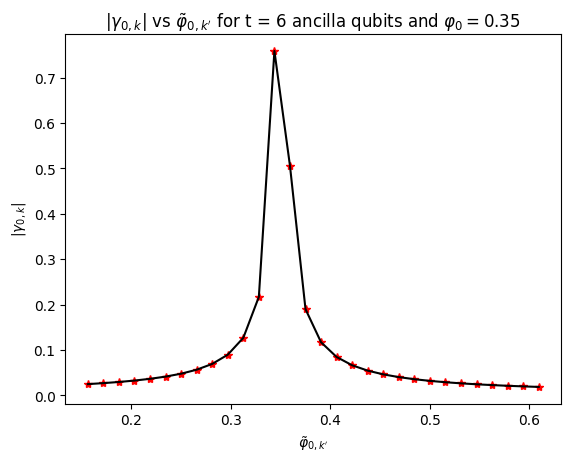

In [18]:
# run code with 6 ancillas
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
gamma = gamma/(np.sqrt(sum(gamma**2))) # calculate |gamma_0,k'| function
plt.plot(kvals[10:40], gamma[10:40], 'r*')
plt.plot(kvals[10:40], gamma[10:40], 'k-')
plt.xlabel("$\u03c6\u0303_{0,k'}$")
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title("$|\u03B3_{0,k}|$ vs $\u03c6\u0303_{0,k'}$ for t = 6 ancilla qubits and $\u03c6_0 = 0.35$")
plt.show() # plot function against possible phases

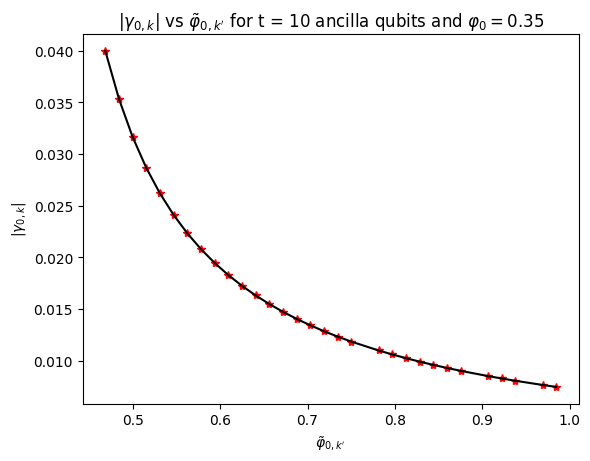

In [19]:
# rerun code above with 10 ancillas and run this cell instead
gamma = 1/((2**(ancilla_bits + 1))*abs(angle - kvals))
gamma = gamma/(np.sqrt(sum(gamma**2))) # calculate |gamma_0,k'| function
plt.plot(kvals[30:75], gamma[30:75], 'r*')
plt.plot(kvals[30:75], gamma[30:75], 'k-')
plt.xlabel("$\u03c6\u0303_{0,k'}$")
plt.ylabel('$|\u03B3_{0,k}|$')
plt.title("$|\u03B3_{0,k}|$ vs $\u03c6\u0303_{0,k'}$ for t = 10 ancilla qubits and $\u03c6_0 = 0.35$")
plt.show() # plot function against possible phases

Inspecting the function, we see that it peaks at $x = 2^n\varphi$, which is the input state.

The binary measurement outcome $k_0'$ can be viewed as a random variable where the probability of obtaining $\tilde{\varphi}_{k_0'}$ at least a distance $\epsilon$ away from the expected value $\varphi_0$ is
\begin{equation}
    \mathbb{P}\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) = \sum_{\left|\varphi_0 - \tilde{\varphi}_{k'}\right|\geq\epsilon}\left|\gamma_{0,k'}\right|^2 \leq \left(\frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1}\right)^2 =  \frac{1}{4T^2\left|\varphi_0 -\tilde{\varphi}_{k'}\right|^2_1},
\end{equation}
where $T = 2^t$. In other words, this expression represents the probability that the estimated phase is not within the desired error. 

Setting $x = \left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1$ this yields 
\begin{equation}
    \mathbb{P}\left(\left|x\right|\geq\epsilon\right) = \sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} =: \sum_{|x|\geq\epsilon} f(x).
\end{equation}

For example, since the accuracy goal is $\epsilon = 2^{-d}$, when $d=5$, $f(x)$ can be visualized with $\epsilon = 0.03125$.

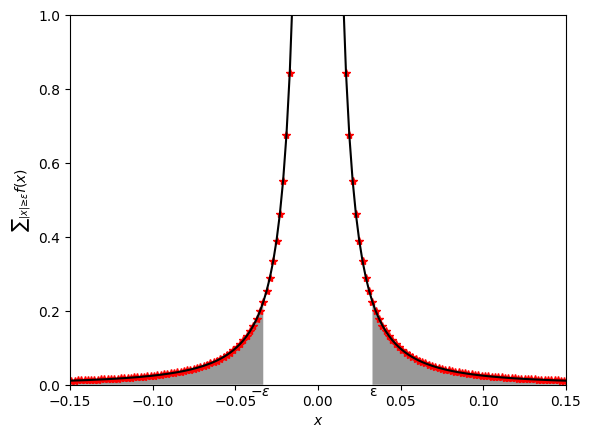

In [20]:
def sum(x):
    sum = 1/(4*(T**2)*(x**2))
    return sum

d = 5
T = 2**d
eps = 1/(2**d)

x = np.linspace(-1,1,1000)
dx1 = x[x >= eps]
dx2 = x[x <= -eps]

func = sum(x)

plt.plot(x, func, 'r*')
plt.plot(x, func, 'k-')

plt.fill_between(dx1, sum(dx1), facecolor='k', alpha=0.4)
plt.fill_between(dx2, sum(dx2), facecolor='k', alpha=0.4)

plt.text(eps,-0.03,'ε')
plt.text(-eps-0.01,-0.03,'$-ε$')

plt.xlabel('$x$')
plt.ylabel('$∑_{|x|≥ ε} f(x)$')
plt.title('')

plt.ylim(0, 1)
plt.xlim(-0.15, 0.15)
plt.show()

Since $f$ is a symmetric function, 
\begin{equation}
    \sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} =
    \sum_{x\geq\epsilon}\frac{2}{4T^2x^2} = \sum_{x\geq\epsilon}\frac{1}{2T^2x^2}.
\end{equation}
As exemplified by \cref{fig:eps}, we see the sum in \cref{eq:epssum} is upper bounded by the integral from $\epsilon$ onwards. Noting that 
\begin{equation}
    \sum_{x\geq\epsilon}\frac{1}{x^2} \leq \int_\epsilon^\infty \frac{1}{x^2}dx = \frac{1}{\epsilon},
\end{equation}
the expression in \cref{eq:epssum} can be bounded, i.e.,
\begin{equation}
    \sum_{|x|\geq\epsilon}\frac{1}{4T^2x^2} \leq \frac{1}{2T^2}\frac{1}{\epsilon} \leq \frac{1}{2T\epsilon},
\end{equation}
because $T\geq1$.
Since $T\epsilon = 2^{t-d}$, we set $t-d = \log_2{(\delta^{-1})}$ so $T\epsilon = \delta ^{-1}$. With $0<\delta<1$, the failure probability is
\begin{equation}
    \mathbb{P}\left(\left|\varphi_0 - \tilde{\varphi}_{k_0'}\right|_1\geq\epsilon\right) \leq \frac{1}{2T\epsilon} = \frac{\delta}{2} \leq \delta.
\end{equation}

When applying the QPE method on a quantum computer, so far we have assumed that both $|\psi\rangle$ is an eigenstate and its phase $\varphi$ has some $d$-bit binary representation. In general, when practically applying this method neither of these conditions can be exactly satsified. To this end it is necessary to analyze this effect on the error of the QPE. So what happens when these conditions are not exactly met? First, as before we assume a unitary operator $U$ has the eigendecomposition 

$$U|\psi_j \rangle = e^{i2\pi \varphi_j}|\psi_j\rangle$$

We assume $0\leq \varphi_0 \leq \varphi_1 \dots \leq \varphi_{N-1}\leq 1$ where we are interested in using QPE to find the phase of the groundstate $\varphi_0$. 

In order to analyze the error, we first relax the first condition, meaning the second condition is assumed to be exactly true. This means that all $\varphi_i$'s have an exact $d$-bit binary representation, but the quantum state is given by some linear combination

$$|\phi\rangle = \sum_{k\in[N]}c_k|\psi_k\rangle$$

where the probability of the ground state is $p_0 = |\langle\phi|\psi_0\rangle|^2 = |c_0|^2 < 1$.

Then applying the QPE procedure to $t$ ancilla qubits and the quantum state $|\phi\rangle$ where $t=d$ because $\varphi$ is represented by a $d$-bit binary number (QPE applied to $|0^t\rangle|\phi\rangle$), measuring the ancilla qubits then returns the binary representation of $\varphi_0$ with probability $p_0$. The system register containing the quantum state also returns the eigenstate $|\psi_0\rangle$ with probability $p_0$. However, in order to realize that $\varphi_0$ is actually the desired phase, some sort of background knowledge of the location of $\varphi_0$ is necessary. For example we must know $\varphi_0 \in (\alpha, \beta)$ and $\varphi_i > \beta$ for all $i \neq 0$. It may then be desirable to relax both of the conditions, discussed above, but this requires a much more involved analysis and additional assumptions. 

To simplify this analysis, we will only consider the case in which the second condition is violated meaning $\varphi_0$ cannot be exactly represented by some binary $d$-bit number. In this case the QPE circuit is still applied to an initial state $|0^t\rangle|\phi\rangle$ but with $t>d$. Taking the converted estimated binary phase to base 10 as $\tilde{\varphi}_{k'} = \frac{k'}{2^t}$ where $k'$ is the binary representation of the phase and applying the QPE to this state gives

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QFT}} \frac{1}{\sqrt{2^t}}\sum_{j\in[2^t]}|j\rangle e^{i2\pi j\varphi_0}|\psi_0\rangle \xrightarrow{\text{QFT}^{\dagger}} \sum_{k'\in[2^t]}\left(\frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}\right)|k'\rangle|\psi_0\rangle$$


Looking at this expression we can clearly see that this is exactly applying the forward followed by the inverse $\text{QFT}$ on the state. For simplicity, we say

$$|0^t\rangle|\psi_0\rangle \xrightarrow{\text{QPE}} \sum_{k'}\gamma_{0,k'}|k'\rangle|\psi_0\rangle \ , \quad \gamma_{0,k'} = \frac{1}{2^t}\sum_{j\in[2^t]}e^{i2\pi j \left(\varphi_0 - \frac{k'}{2^t}\right)}$$

Recall that a geometric series of the form $S = a + ar^2 + ar^3 + \dots + ar^n$ can be represented as the formula

$$S = \frac{a(r^n-1)}{r-1}$$

Recognizing that $\gamma_{0,k'}$ is a gemotric series with the common ratio $r = e^{i2\pi \left(\varphi_0 - \frac{k'}{2^t}\right)}$ and the coefficient $a = \frac{1}{2^t}$, this can be further simplified by

$$\gamma_{0,k'} = \frac{1}{2^t}\frac{1-r^{2^t}}{1-r} = \frac{1}{2^t}\frac{1-e^{i\pi 2^{t+1} \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}{1-e^{i2\pi \left(\varphi_0 - \tilde{\varphi}_{k'}\right)}}$$

From this expression we can tell that for the case in which $\varphi_0$ has an exact $d$-bit representation meaning $\varphi_0 = \tilde{\varphi}_{k_0'}$ for some $k_0'$, then $\gamma_{0,k'} = \delta_{k',k_0'}$ the Dirac delta function as shown in the plots below. This is to say that if there is an exact $d$-bit representation of the phase $\varphi_0$, one run of the QPE circuit will give the value $\varphi_0$ deterministically. Now assume that $\varphi_0 \neq \tilde{\varphi}_{k'}$ for any $k'$. Since $e^{i2\pi x}$ is a periodic function with a period of $1$, we can only find the value of $x \mod{1}$. Therefore, when estimating the phase $k_0'$ we are aiming for precision $\epsilon = \frac{1}{2^d} = \frac{2^{t-d}}{2^t}$ such that 

$$\left|\varphi_0-\tilde{\varphi}_{k_0'}\right|_1<\epsilon$$

Using the relationship that for any $\theta \in [-\pi,\pi]$

$$\left|1-e^{i\theta}\right| = \left|(1-\cos\theta)-i\sin\theta\right| = \sqrt{(1-\cos\theta)^2 + \sin\theta} = \sqrt{2(1-\cos\theta)} = 2\left|\sin\frac{\theta}{2}\right|\geq\frac{2}{\pi}\left|\theta\right|$$

and that

$$\left|1 - e^{i\theta}\right| \leq \left|1\right| + \left|e^{i\theta}\right| = \sqrt{1^2} + \sqrt{\cos^2\theta - (i\sin\theta)^2} = 1 + \sqrt{\cos^2\theta + \sin^2\theta} = 1 + 1 = 2$$

we find that 

$$\left|\gamma_{0,k'}\right| \leq \frac{2}{2^t2\pi\frac{2}{\pi}\left|\varphi_0 - \tilde{\varphi}_{k'}\right|_1} = \frac{1}{2^{t+1}\left|\varphi_0 -\tilde{\varphi}_{k'}\right|_1} $$

Now, we will plot $|\gamma_{0,k'}|$ against the phase $\varphi_{0,k'}$ for a couple different values of ancilla bits $t$. Using a phase of $\varphi_0=0.35$, we should see $|\gamma_{0,k'}|$ approach the Dirac delta function $\delta_{k',k_0'}$ at this value.

First, we set the phase to be estimated by the algorithm and convert it into its $t$-bit binary representation where $t$ is the number of ancilla bits. The quantum circuit circuit is then initizalized with $1$ more than the desired number of ancilla qubits. An $H$ gate is applied to all but $1$ of the qubits. These are the ancillas. The last qubit represents the quantum state $|\psi\rangle$ which is prepared with an $X$ gate. A for loop then applies all the $C-U$ operations targeted to the state $|\psi\rangle$ and controlled by each ancilla bit. Finally, the $\text{QFT}^{\dagger}$ function defined above is applied to the circuit, and every ancilla bit is measured. 